In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [2]:
%load_ext autoreload
%autoreload 2

In [167]:
import matplotlib.pyplot as plt
import contextily as cx
from rasterio.crs import CRS
from pathlib import Path
import pickle
from shapely.geometry import Polygon, Point, box
import pandas as pd
from geopandas import gpd
import numpy as np

In [103]:
# helper functions

# the below two functions help grid the data into 1 degree by 1 degree boxes
def get_lat(geom):
    return int(np.floor(geom.centroid.coords.xy[1][0]))
def get_lon(geom):
    return int(np.floor(geom.centroid.coords.xy[0][0]))

# creates the 1 degree by 1 degree box
def make_box(row):
    return box(row['lon'], row['lat'], row['lon'] + 1, row['lat'] + 1)

In [160]:
def calculate_averages(results):
    
    results['lat_lon_str'] = results.apply(lambda row: str(row['center_x']) + '_' + str(row['center_y']), axis=1)
    
    df = pd.DataFrame(columns = ['av_cad_days','avail_sensors','n_avail_sensors'])
    
    df['av_cad_days'] = [results[results.lat_lon_str == i].cadence.mean().total_seconds()/(3600 * 24) for i in results.lat_lon_str.unique()]
    df['avail_sensors'] = [results[results.lat_lon_str == i].sensor.unique() for i in results.lat_lon_str.unique()]
    df['n_avail_sensors'] = [len(results[results.lat_lon_str == i].sensor.unique()) for i in results.lat_lon_str.unique()]
    geometry = [Point(float(i.split('_')[0]), float(i.split('_')[1])) for i in results.lat_lon_str.unique()]
    df = gpd.GeoDataFrame(df, geometry=geometry, crs=CRS.from_epsg(4326))
    
    return df

In [5]:
# Re-grid results to 1x1 degree cells
def regrid(df_temp: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    
    df_temp['lon'] = df_temp.geometry.map(get_lon)
    df_temp['lat'] = df_temp.geometry.map(get_lat)
    
    return df_temp

# Use geodataframe groupby function to aggregate rows to 1 by 1 degree box
def aggregator(df_temp: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    df_ag = df_temp.groupby(['lon', 'lat']).mean().reset_index()
    geom = df_ag.apply(make_box, axis=1)
    df_ag = gpd.GeoDataFrame(df_ag,
                             geometry=geom,
                             crs = CRS.from_epsg(4326))
    return df_ag

In [165]:
def get_boxes(results: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    
    df = calculate_averages(results)
    df = regrid(df)
    df_ag = aggregator(df)
    
    return df_ag

In [205]:
output_path = Path('../output_dfs')
dfs = sorted(list(output_path.glob('*_results.pkl')))
print(dfs)

[PosixPath('../output_dfs/Africa_results.pkl'), PosixPath('../output_dfs/Asia_results.pkl'), PosixPath('../output_dfs/Europe_results.pkl')]


In [206]:
continent_list = ['Africa','Asia','Europe'] # ,'N_America','Oceania','S_America'
continents = {}
for i in range(len(continent_list)):
    with open(dfs[i], 'rb') as f:
        continents[continent_list[i]] = pickle.load(f)

In [176]:
df = get_boxes(africa)

In [ ]:
continents['Africa']

In [ ]:
continents['Asia']

### Plotting functions

Text(0.5, 1.0, 'Africa Coverage Cadence in Days')

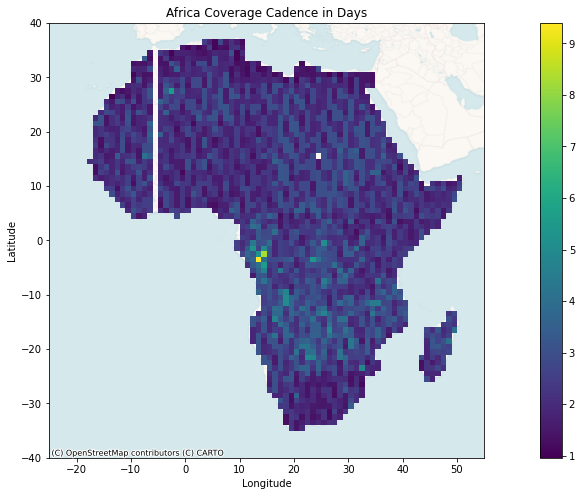

In [184]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(-25,55)
ax.set_ylim(-40,40)
africa_plot = df.plot(column='av_cad_days', ax=ax, legend=True)
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Africa Coverage Cadence in Days')

In [187]:
test_df = africa[africa.sensor == 'sentinel1']
test_df = get_boxes(test_df)

/Users/angelac/miniconda3/envs/opera_coverage/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Text(0.5, 1.0, 'Africa Coverage Cadence in Days (Sentinel-2 only)')

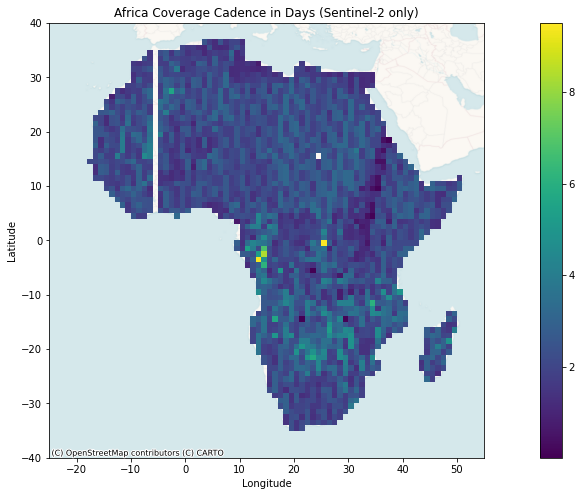

In [203]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(-25,55)
ax.set_ylim(-40,40)
africa_plot = test_df.plot(column='av_cad_days', ax=ax, legend=True)
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Africa Coverage Cadence in Days (Sentinel-2 only)')

In [190]:
test_df = africa[africa.sensor == 'sentinel2']
test_df = get_boxes(test_df)

/Users/angelac/miniconda3/envs/opera_coverage/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [200]:
with open(test[0], 'rb') as f:
    test = pickle.load(f)
test = get_boxes(test)

Text(0.5, 1.0, 'Global Coverage Cadence in Days')

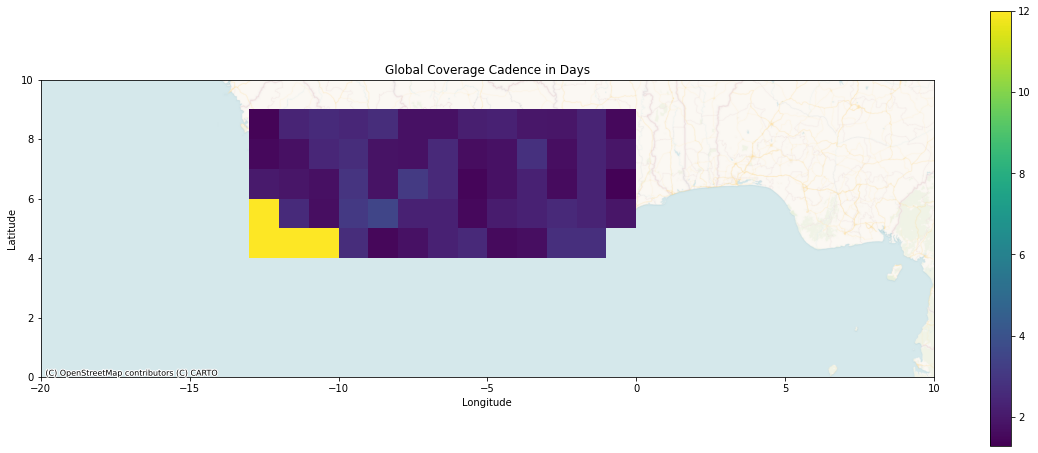

In [202]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(-20,10)
ax.set_ylim(0,10)
plott = test.plot(column='av_cad_days', ax=ax, legend=True)
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Global Coverage Cadence in Days')

In [198]:
test

,lon,lat,av_cad_days,n_avail_sensors,geometry
0,-7,5,2.272732,3.0,"POLYGON ((-6.00000 5.00000, -6.00000 6.00000, ..."
1,-7,7,2.272732,3.0,"POLYGON ((-6.00000 7.00000, -6.00000 8.00000, ..."
2,-7,8,1.548586,3.0,"POLYGON ((-6.00000 8.00000, -6.00000 9.00000, ..."
3,-6,5,1.226959,3.0,"POLYGON ((-5.00000 5.00000, -5.00000 6.00000, ..."
4,-6,7,1.315827,3.0,"POLYGON ((-5.00000 7.00000, -5.00000 8.00000, ..."
5,-6,8,2.193097,3.0,"POLYGON ((-5.00000 8.00000, -5.00000 9.00000, ..."
